# Лабораторная работа 4

In [28]:
! pip install xgboost

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.feature_selection import f_classif

from xgboost import XGBClassifier


Загрузка датасета

In [30]:
import pandas as pd

CSV_PATH = "credit_scoring.csv"

df = pd.read_csv(CSV_PATH)
df.head()


,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
0,0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


EDA (первичный анализ)

общий анализ

In [31]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              75000 non-null  int64  
 1   DIR                    75000 non-null  float64
 2   Age                    75000 non-null  float64
 3   NumLoans               75000 non-null  int64  
 4   NumRealEstateLoans     75000 non-null  int64  
 5   NumDependents          73084 non-null  float64
 6   Num30-59Delinquencies  75000 non-null  int64  
 7   Num60-89Delinquencies  75000 non-null  int64  
 8   Income                 60153 non-null  float64
 9   BalanceToCreditLimit   75000 non-null  float64
 10  Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 6.3 MB


,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
0,0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


пропуски и статистика по числам

In [32]:
display(df.isna().sum().to_frame("missing"))
display(df.describe().T)

,missing
client_id,0
DIR,0
Age,0
NumLoans,0
NumRealEstateLoans,0
NumDependents,1916
Num30-59Delinquencies,0
Num60-89Delinquencies,0
Income,14847
BalanceToCreditLimit,0


,count,mean,std,min,25%,50%,75%,max
client_id,75000.0,37499.500000,21650.779432,0.0,18749.750000,37499.500000,56249.250000,7.499900e+04
DIR,75000.0,353.260293,2117.237432,0.0,0.176022,0.366848,0.862650,3.326003e+05
Age,75000.0,52.595605,14.869729,21.0,41.300000,52.200000,63.100000,1.098000e+02
NumLoans,75000.0,8.449760,5.156440,0.0,5.000000,8.000000,11.000000,5.600000e+01
NumRealEstateLoans,75000.0,1.016693,1.124019,0.0,0.000000,1.000000,2.000000,3.200000e+01
NumDependents,73084.0,0.755966,1.108119,0.0,0.000000,0.000000,1.000000,2.000000e+01
Num30-59Delinquencies,75000.0,0.428320,4.276439,0.0,0.000000,0.000000,0.000000,9.800000e+01
Num60-89Delinquencies,75000.0,0.248000,4.239486,0.0,0.000000,0.000000,0.000000,9.800000e+01
Income,60153.0,6740.059287,14228.754880,0.0,3421.353782,5424.552473,8291.517816,1.805573e+06
BalanceToCreditLimit,75000.0,6.276196,267.743321,0.0,0.029703,0.153720,0.560638,5.087387e+04


Распределение таргета

In [33]:
display(df["Delinquent90"].value_counts())
display((df["Delinquent90"].value_counts(normalize=True) * 100).round(2))

Delinquent90
0    69987
1     5013
Name: count, dtype: int64

Delinquent90
0    93.32
1     6.68
Name: proportion, dtype: float64

Гистограммы признаков

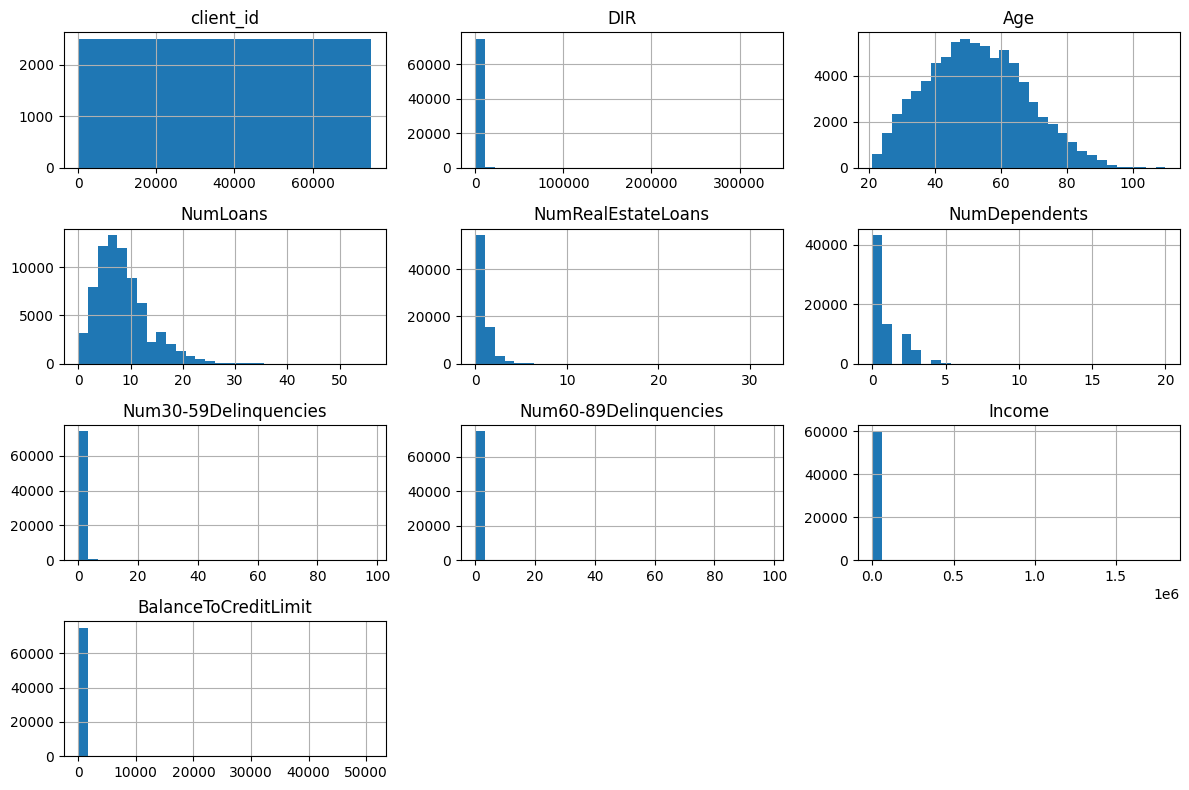

In [34]:
num_cols = [c for c in df.columns if c != "Delinquent90"]
df[num_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Корреляции

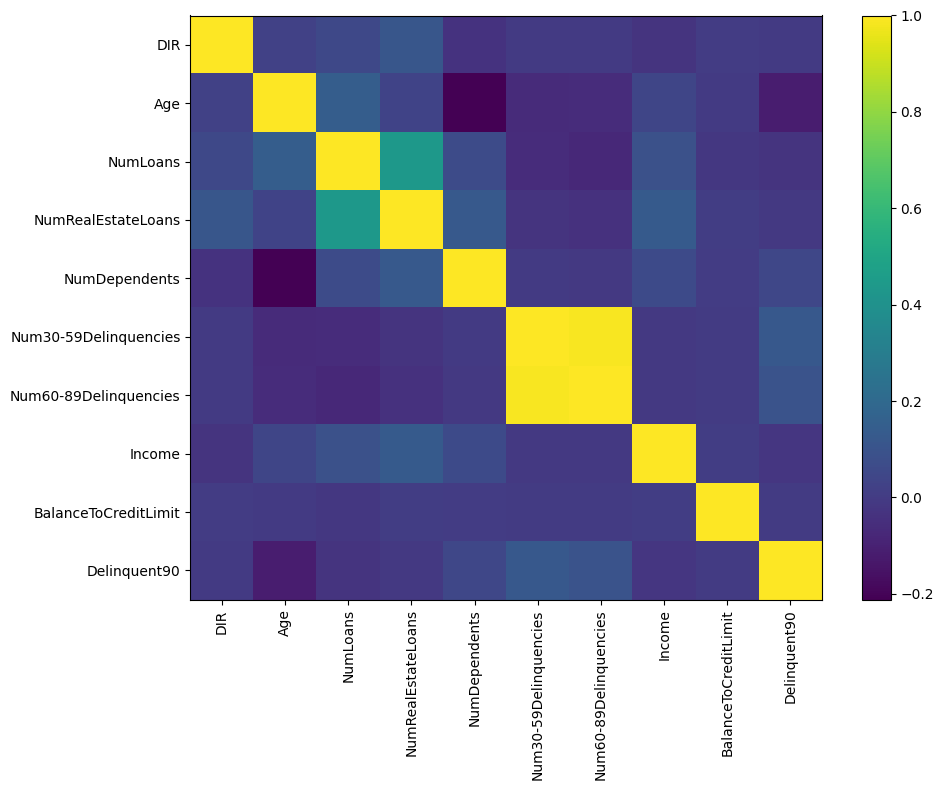

In [35]:
corr = df.drop(columns=["client_id"]).corr(numeric_only=True)
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

Предобработка + скалирование + подготовка данных

In [36]:
y = df["Delinquent90"].astype(int)
X = df.drop(columns=["Delinquent90", "client_id"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

prep = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


Дерево решений + визуализация

Accuracy: 0.893


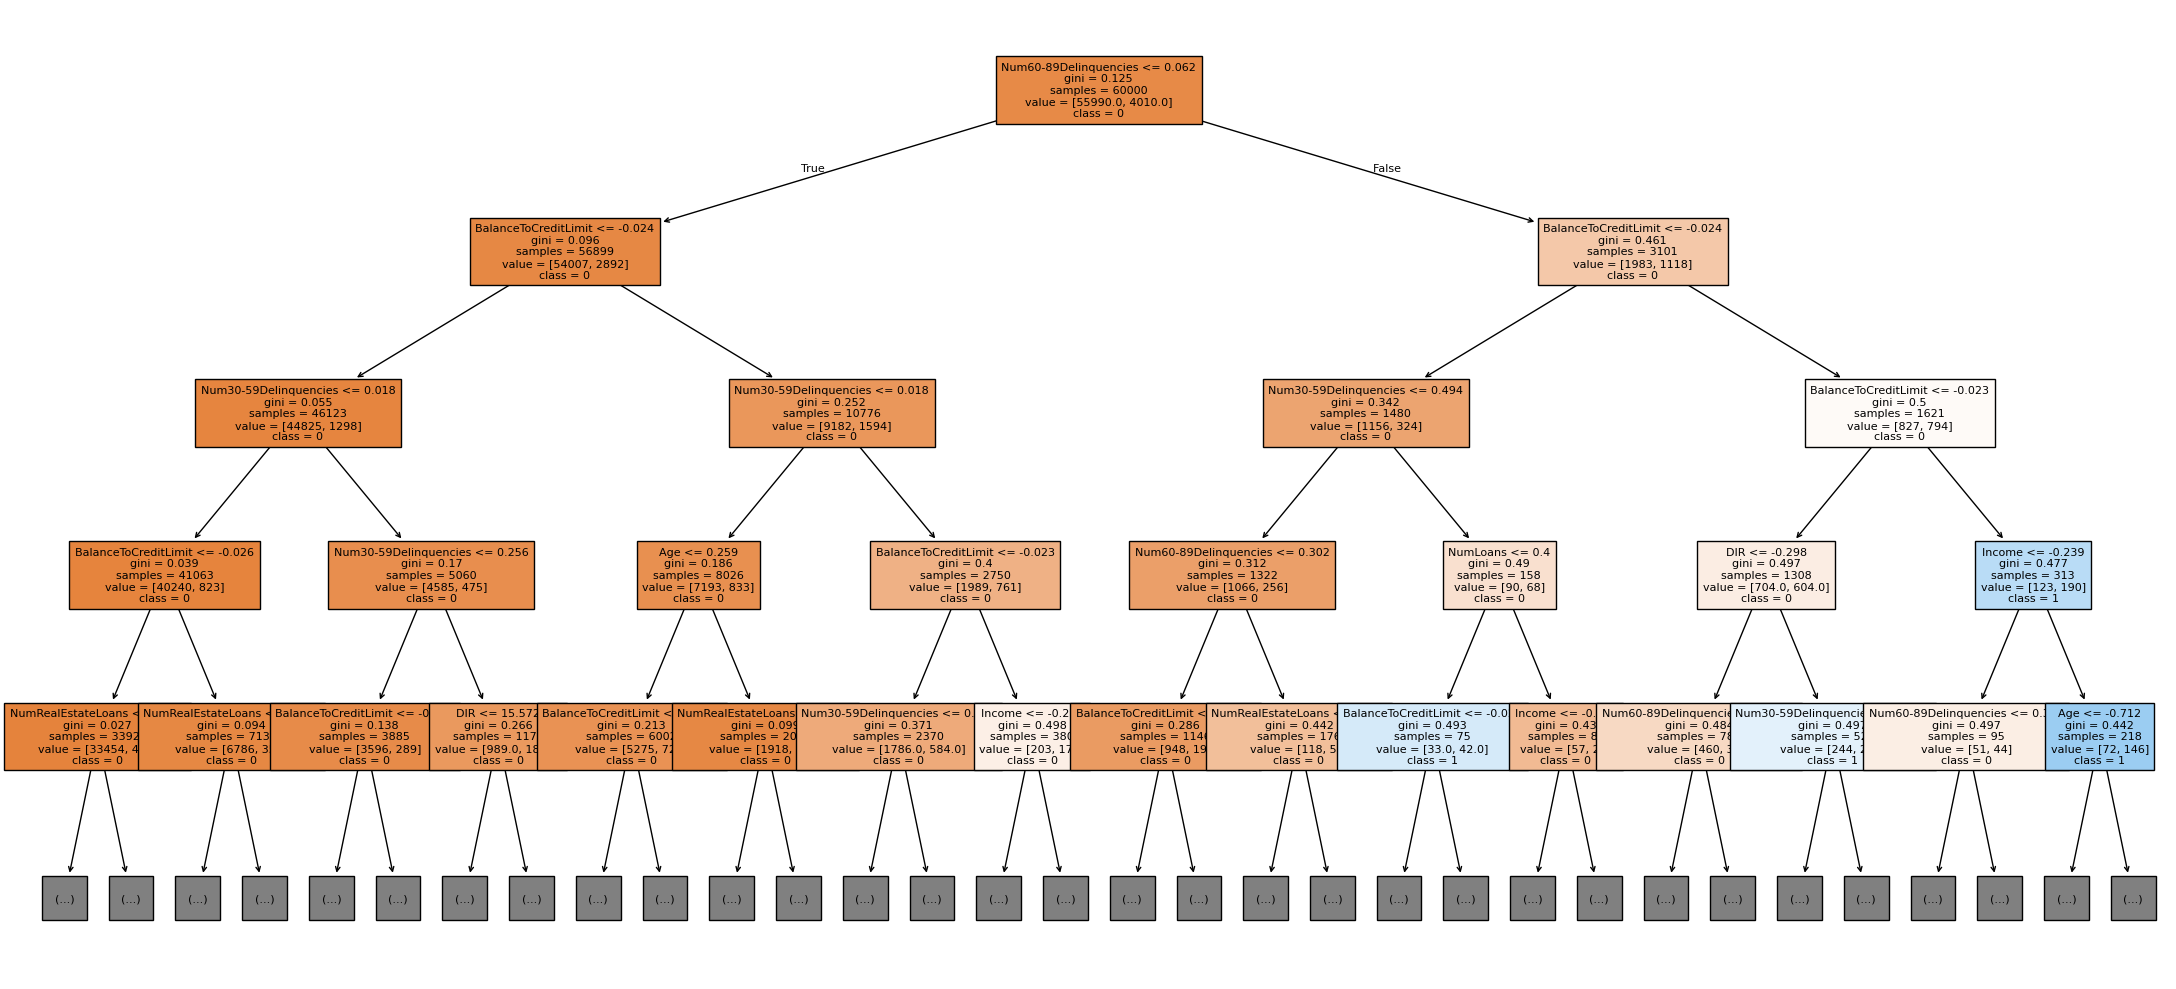

In [37]:
dt_pipe = Pipeline([
    ("prep", prep),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_pipe.fit(X_train, y_train)
y_pred = dt_pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

tree = dt_pipe.named_steps["clf"]
plt.figure(figsize=(22, 10))
plot_tree(tree, feature_names=X.columns, class_names=["0", "1"], filled=True, max_depth=4, fontsize=8)
plt.tight_layout()
plt.show()


Глубина дерева

,max_depth,train_acc,test_acc
0,1,0.933167,0.933133
1,2,0.933167,0.933133
2,3,0.934283,0.934133
3,4,0.935217,0.931933
4,5,0.935933,0.933600
5,6,0.936817,0.932600
6,7,0.938467,0.934133


Best depth: 3
Overfitting starts: 4


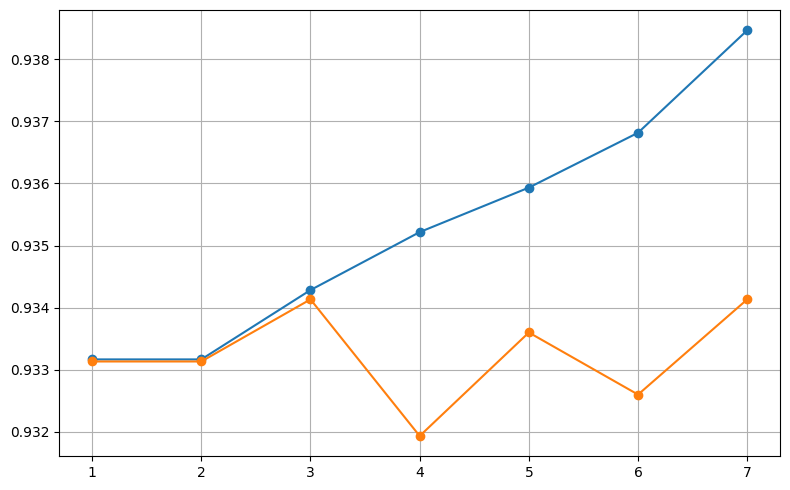

In [38]:
depths = range(1, 8)
train_acc, test_acc = [], []

for d in depths:
    pipe = Pipeline([
        ("prep", prep),
        ("clf", DecisionTreeClassifier(max_depth=d, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, pipe.predict(X_train)))
    test_acc.append(accuracy_score(y_test, pipe.predict(X_test)))

res = pd.DataFrame({"max_depth": list(depths), "train_acc": train_acc, "test_acc": test_acc})
display(res)

best_depth = int(res.loc[res["test_acc"].idxmax(), "max_depth"])
print("Best depth:", best_depth)

overfit_start = None
for i in range(1, len(res)):
    if res.loc[i, "train_acc"] > res.loc[i-1, "train_acc"] and res.loc[i, "test_acc"] < res.loc[i-1, "test_acc"]:
        overfit_start = int(res.loc[i, "max_depth"])
        break
print("Overfitting starts:", overfit_start)

plt.figure(figsize=(8, 5))
plt.plot(res["max_depth"], res["train_acc"], marker="o")
plt.plot(res["max_depth"], res["test_acc"], marker="o")
plt.xticks(list(depths))
plt.grid(True)
plt.tight_layout()
plt.show()


Таким образом, оптимальная глубина: 3. Переобучение начинается с 4

GridSearchCV для дерева решений

In [40]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_pipe = Pipeline([
    ("prep", prep),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": list(range(1, 21)),
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5]
}

gs_dt = GridSearchCV(dt_pipe, dt_grid, scoring="accuracy", cv=cv, n_jobs=-1)
gs_dt.fit(X_train, y_train)

print("Best params:", gs_dt.best_params_)
print("CV best accuracy:", gs_dt.best_score_)

y_pred = gs_dt.best_estimator_.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))


Best params: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
CV best accuracy: 0.93435
Test accuracy: 0.9326


Бэггинг (BaggingClassifier) + GridSearchCV (база: KNN)

модель обучалась очень долго, решил прикрутить прогресс бар и попытаться её ускорить

In [ ]:
!pip install tqdm_joblib

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib


Pipeline

In [42]:
bag_pipe = Pipeline([
    ("prep", prep),
    ("bag", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42,
        n_jobs=1
    ))
])


Сетка параметров

In [43]:
bag_grid_fast = {
    "bag__n_estimators": [25, 50],
    "bag__max_samples": [0.7, 1.0],
    "bag__max_features": [0.7, 1.0],
    "bag__estimator__max_depth": [2, 3, 4, None],
    "bag__estimator__min_samples_leaf": [1, 5]
}


CV

In [44]:
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [45]:
total_fits = len(list(ParameterGrid(bag_grid_fast))) * cv_fast.get_n_splits()

gs_bag = GridSearchCV(
    bag_pipe,
    bag_grid_fast,
    scoring="accuracy",
    cv=cv_fast,
    n_jobs=-1
)

with tqdm_joblib(tqdm(total=total_fits, desc="GridSearch fits")):
    gs_bag.fit(X_train, y_train)

y_pred = gs_bag.best_estimator_.predict(X_test)
print("Best params:", gs_bag.best_params_)
print("CV best accuracy:", gs_bag.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_pred))


GridSearch fits:   0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

Best params: {'bag__estimator__max_depth': None, 'bag__estimator__min_samples_leaf': 5, 'bag__max_features': 0.7, 'bag__max_samples': 0.7, 'bag__n_estimators': 50}
CV best accuracy: 0.9350833333333334
Test accuracy: 0.9348


Стекинг (StackingClassifier) + GridSearchCV

In [47]:
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stack = StackingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)),
        ("dt", DecisionTreeClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=2000, solver="liblinear", random_state=42),
    cv=3,
    n_jobs=-1
)

stack_pipe = Pipeline([
    ("prep", prep),
    ("stack", stack)
])

stack_grid_fast = {
    "stack__lr__C": [0.1, 1.0, 10.0],
    "stack__dt__max_depth": [2, 3, 4, None],
    "stack__final_estimator__C": [0.1, 1.0, 10.0]
}

total_fits = len(list(ParameterGrid(stack_grid_fast))) * cv_fast.get_n_splits()

gs_stack = GridSearchCV(stack_pipe, stack_grid_fast, scoring="accuracy", cv=cv_fast, n_jobs=-1)

with tqdm_joblib(tqdm(total=total_fits, desc="GridSearch fits")):
    gs_stack.fit(X_train, y_train)

y_pred = gs_stack.best_estimator_.predict(X_test)
print("Best params:", gs_stack.best_params_)
print("CV best accuracy:", gs_stack.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_pred))

GridSearch fits:   0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Best params: {'stack__dt__max_depth': 4, 'stack__final_estimator__C': 0.1, 'stack__lr__C': 10.0}
CV best accuracy: 0.9340833333333333
Test accuracy: 0.9323333333333333


RandomForestClassifier + GridSearchCV

In [49]:
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_pipe = Pipeline([
    ("prep", prep),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_grid_fast = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 8, 12],
    "rf__min_samples_split": [2, 10],
    "rf__min_samples_leaf": [1, 5],
    "rf__max_features": ["sqrt", 0.7]
}

total_fits = len(list(ParameterGrid(rf_grid_fast))) * cv_fast.get_n_splits()

gs_rf = GridSearchCV(rf_pipe, rf_grid_fast, scoring="accuracy", cv=cv_fast, n_jobs=-1)

with tqdm_joblib(tqdm(total=total_fits, desc="GridSearch fits")):
    gs_rf.fit(X_train, y_train)

y_pred = gs_rf.best_estimator_.predict(X_test)
print("Best params:", gs_rf.best_params_)
print("CV best accuracy:", gs_rf.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_pred))

GridSearch fits:   0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

Best params: {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
CV best accuracy: 0.9355333333333333
Test accuracy: 0.9348


XGBoost + F-test для важности признаков

In [51]:
X_train_p = prep.fit_transform(X_train)
X_test_p = prep.transform(X_test)

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb.fit(X_train_p, y_train)
y_pred = xgb.predict(X_test_p)
print("Test accuracy:", accuracy_score(y_test, y_pred))

F, p = f_classif(X_train_p, y_train)
f_table = pd.DataFrame({"feature": X.columns, "F_stat": F, "p_value": p}).sort_values("F_stat", ascending=False)
display(f_table)


Test accuracy: 0.9340666666666667


,feature,F_stat,p_value
5,Num30-59Delinquencies,786.430374,6.233265e-172
1,Age,762.426217,8.858454e-167
6,Num60-89Delinquencies,491.671820,1.686162e-108
4,NumDependents,129.873449,4.690117e-30
2,NumLoans,52.023573,5.548374e-13
7,Income,16.263101,5.519518e-05
3,NumRealEstateLoans,3.182249,7.444726e-02
8,BalanceToCreditLimit,1.022214,3.119984e-01
0,DIR,0.921002,3.372159e-01


Вывод

Лучшие результаты на тесте показали Bagging и RandomForest: accuracy = 0.9348.

XGBoost почти не уступает: 0.9341.

DecisionTree и Stacking дали чуть ниже: 0.9326 и 0.9323.

В целом различия небольшие (~0.0025), но ансамбли в среднем работают лучше одиночных моделей.